# Decoder

This is a continuation of the `helloworld` notebook, now focused on decoding the bits of the `digital_stream`. This notebook is based on a larger capture of the same signal as in the `helloworld` notebook. The transmitter seems to send the same signal four times per button press, and continuously when pressing and holding the button.

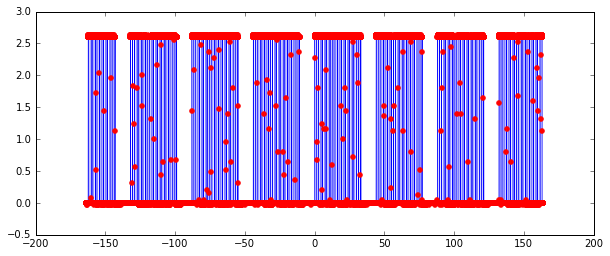

In [372]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csv = np.genfromtxt('data/a1on.csv', delimiter=',', skip_header=2, usecols=(0, 1))
csv = np.transpose(csv)
time = csv[0] * 1000  # time in ms
voltage = csv[1]

def oscilloscope(x, y, width=10, height=4, start=0, stop=None, linewidth=0.5):
    fig = plt.figure(figsize=(width, height))
    axes = fig.add_subplot(111)
    axes.plot(x[start:stop], y[start:stop], marker='o', mec='red', mfc='red', markersize=5, linewidth=linewidth)
    plt.show()

oscilloscope(time, voltage)

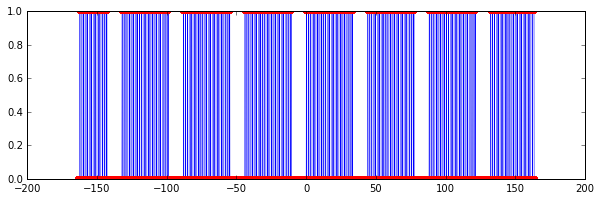

In [373]:
digital_one = np.percentile(voltage, 90)
digital_stream = voltage / digital_one
digital_stream = digital_stream.round().astype(int)
oscilloscope(time, digital_stream, height=3)

### The Clean Digital Stream
I captured part of two messages and 6 whole messages. Let's zoom and to take a closer look at a single message:

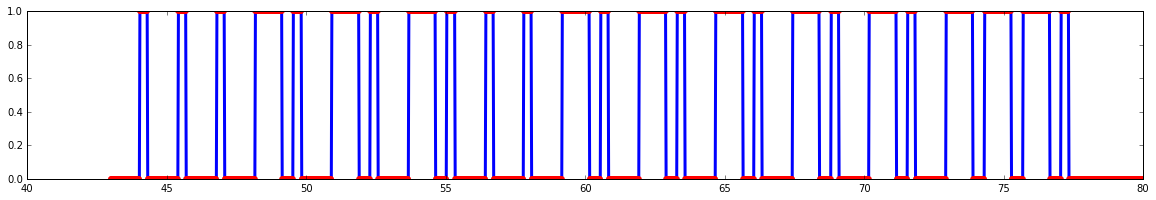

In [374]:
start = 43
stop = 80
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
start_index = time.tolist().index(find_nearest(time, start))
stop_index = time.tolist().index(find_nearest(time, stop))

oscilloscope(time, digital_stream, height=3, start=start_index, stop=stop_index, width=20, linewidth=3)

What's the duration of a single data point? With this number we can later convert between the duration in terms of data point count to time in nano seconds.

In [375]:
number_of_data_points = len(digital_stream)
first_capture_time = time[0]
last_capture_time = time[-1]
total_capture_duration = last_capture_time - first_capture_time

single_data_point_duration = total_capture_duration / (number_of_data_points - 1) * 1000
print single_data_point_duration, 'ns'

20.0 ns


### Introducing the Concept of a Signal
Below is another part of the digital stream. Clean stream of ones and zeroes. It could perhaps be represented as a list of signals, where a signal is represented by something that can indicate high/low and has a duration?

In [376]:
print '/.../', ', '.join([str(x) for x in digital_stream[13000:13200]]), '/.../'

/.../ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 /.../


Let's populate a `signals` list with this new Signal data type:

In [377]:
from collections import namedtuple

Signal = namedtuple('Signal', ['high', 'duration'])
HIGH = 1

signals = []

first = True
previous = None
duration = None
last_index = len(digital_stream) - 1
for i, x in enumerate(digital_stream):
    if first:
        first = False
        previous = x
        duration = 1
        continue;

    if i == last_index or x != previous:
        high = previous == HIGH
        s = Signal(high=high, duration=duration)
        signals.append(s)
        
        previous = x
        duration = 1
    else:
        duration += 1

Now we take a look and print the table of `signals`:

In [378]:
print pd.DataFrame(data=signals)

      high  duration
0    False        74
1     True        14
2    False        55
3     True        48
4    False        21
5     True        14
6    False        55
7     True        48
8    False        20
9     True        14
10   False        55
11    True        49
12   False        20
13    True        14
14   False        55
15    True        48
16   False        20
17    True        15
18   False        54
19    True        49
20   False        20
21    True        14
22   False        55
23    True        48
24   False        20
25    True        49
26   False        20
27    True        49
28   False        21
29    True        13
..     ...       ...
347   True        14
348  False        55
349   True        14
350  False        54
351   True        15
352  False        54
353   True        49
354  False        20
355   True        14
356  False        55
357   True        48
358  False        21
359   True        14
360  False        54
361   True        49
362  False   

### Signal Pairs
Looks great. The bits seem to be encoded in pairs where the sum of high + low durations are somewhat constant. Let's add this information to the data model by pairing them:

In [379]:
signal_pairs = []
first = None
for index, s in enumerate(signals):
    if index == 0 and s.high != True:
        # If the data begins with a low signal, drop it.
        continue;
    
    if first == None:
        first = s
    else:
        signal_pairs.append((first, s))
        first = None

print pd.DataFrame(data=signal_pairs)

              0             1
0    (True, 14)   (False, 55)
1    (True, 48)   (False, 21)
2    (True, 14)   (False, 55)
3    (True, 48)   (False, 20)
4    (True, 14)   (False, 55)
5    (True, 49)   (False, 20)
6    (True, 14)   (False, 55)
7    (True, 48)   (False, 20)
8    (True, 15)   (False, 54)
9    (True, 49)   (False, 20)
10   (True, 14)   (False, 55)
11   (True, 48)   (False, 20)
12   (True, 49)   (False, 20)
13   (True, 49)   (False, 21)
14   (True, 13)  (False, 537)
15   (True, 14)   (False, 55)
16   (True, 14)   (False, 55)
17   (True, 13)   (False, 55)
18   (True, 49)   (False, 20)
19   (True, 14)   (False, 55)
20   (True, 48)   (False, 20)
21   (True, 15)   (False, 55)
22   (True, 48)   (False, 20)
23   (True, 14)   (False, 55)
24   (True, 14)   (False, 55)
25   (True, 14)   (False, 54)
26   (True, 49)   (False, 20)
27   (True, 14)   (False, 55)
28   (True, 49)   (False, 20)
29   (True, 14)   (False, 55)
..          ...           ...
158  (True, 14)   (False, 55)
159  (True

### Signal Pair Duration
What's the duration of every signal pair?

In [380]:
pair_durations = [pair[0].duration + pair[1].duration for pair in signal_pairs]
print pair_durations

[69, 69, 69, 68, 69, 69, 69, 68, 69, 69, 69, 68, 69, 70, 550, 69, 69, 68, 69, 69, 68, 70, 68, 69, 69, 68, 69, 69, 69, 69, 69, 69, 68, 69, 69, 69, 68, 69, 69, 550, 69, 69, 69, 68, 69, 69, 69, 69, 69, 68, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 69, 69, 69, 69, 550, 69, 68, 69, 69, 69, 69, 68, 70, 68, 69, 69, 68, 70, 68, 69, 69, 68, 69, 69, 69, 69, 69, 68, 69, 550, 70, 68, 69, 69, 69, 68, 69, 70, 68, 69, 68, 69, 69, 69, 69, 68, 70, 68, 69, 69, 68, 69, 69, 69, 550, 69, 69, 69, 68, 69, 69, 69, 68, 70, 68, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 69, 69, 69, 68, 551, 69, 69, 68, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 69, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 551, 69, 68, 69, 69, 69, 68, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 69, 69, 69, 68, 69, 69, 72]


How are the pair durations distributed?

In [381]:
counts, values = np.histogram(pair_durations)

def print_table(data, columns):
    print pd.DataFrame(data=data, columns=columns)

print_table(zip(counts, values), ['count', 'bucket'])

   count  bucket
0    181    68.0
1      0   116.3
2      0   164.6
3      0   212.9
4      0   261.2
5      0   309.5
6      0   357.8
7      0   406.1
8      0   454.4
9      7   502.7


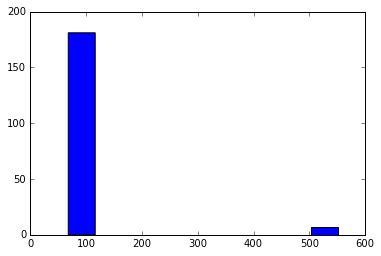

In [382]:
plt.hist(pair_durations)
plt.show()

It's obvious that a single value here is the most common one, and that outliers are the time between messages and the beginning and end of the signal capture. Let's define the signal pair duration to be the most common signal pair duration:

In [383]:
from collections import Counter
c = Counter(pair_durations)
print c
signal_pair_duration = c.most_common()[0][0]
print signal_pair_duration

Counter({69: 129, 68: 43, 70: 8, 550: 5, 551: 2, 72: 1})
69


### Separating Messages
It seems like we can use the duration of the low signal as the separator between messages. Let's define the duration of a separating low signal as if it's more than double the length of the two most common signal pairs. At the same time, after we are done using the knowledge that the longer durations are separating messages, let's normalize those signal pairs.

In [384]:
separator_limit = signal_pair_duration * 2

messages = []
message = []
last_pair_index = len(signal_pairs) - 1
for i, sp in enumerate(signal_pairs):

    # Detect separating signal
    high, low = sp
    is_separating_signal = low.duration > separator_limit
    
    # Normalize separating signals:
    # The signal that is closes to the most common signal pair duration is the reliable one of the pair.
    distance_to_high = abs(signal_pair_duration - high.duration)
    distance_to_low = abs(signal_pair_duration - low.duration)
    if distance_to_high < distance_to_low:
        # The high signal is the reliable one
        new_low = low._replace(duration=signal_pair_duration - high.duration)
        message.append((high, new_low))
    else:
        # The low signal is the reliable one
        new_high = high._replace(duration=signal_pair_duration - low.duration)
        message.append((new_high, low))

    if i == last_pair_index or is_separating_signal:
        messages.append(message)
        message = []

print len(messages)
messages

8


[[(Signal(high=True, duration=14), Signal(high=False, duration=55)),
  (Signal(high=True, duration=48), Signal(high=False, duration=21)),
  (Signal(high=True, duration=14), Signal(high=False, duration=55)),
  (Signal(high=True, duration=48), Signal(high=False, duration=21)),
  (Signal(high=True, duration=14), Signal(high=False, duration=55)),
  (Signal(high=True, duration=49), Signal(high=False, duration=20)),
  (Signal(high=True, duration=14), Signal(high=False, duration=55)),
  (Signal(high=True, duration=48), Signal(high=False, duration=21)),
  (Signal(high=True, duration=15), Signal(high=False, duration=54)),
  (Signal(high=True, duration=49), Signal(high=False, duration=20)),
  (Signal(high=True, duration=14), Signal(high=False, duration=55)),
  (Signal(high=True, duration=48), Signal(high=False, duration=21)),
  (Signal(high=True, duration=49), Signal(high=False, duration=20)),
  (Signal(high=True, duration=49), Signal(high=False, duration=20)),
  (Signal(high=True, duration=13),

### Decoding the Bits of the Messages
Now that we have separate clean messages, it's time to decode the actual digital bits. The ratio between high and low signal durations seems like the perfect thing for us here. Let's assume the pair with the long high period is a digital one and the short high period is a digital zero.

In [385]:
from itertools import chain

bit_messages = []
for message in messages:
    bit_message = []
    for high, low in message:
        bit = high.duration > low.duration
        bit_message.append(bit)
    bit_messages.append(bit_message)

Now what about the lengths of the bit messages?

In [386]:
print map(len, bit_messages)

[15, 25, 25, 25, 25, 25, 25, 23]


### Result
Now we print the decoded data! :D

In [387]:
for m in bit_messages:
    msg = ''
    for b in m:
        msg += '1' if b else '0'
    print msg

010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
0001010100010101010101110
00010101000101010101011
